# Week 8: Text Mining

### What's on this week
1. [Loading text data](#load)
2. [Data preprocessing](#prep)
3. [Document analysis](#analyse)
3. [Feature selection and transformation](#transform)

---

### Important Changelog:
* (08/10/2017) Made tutorial notes public.
* (10/10/2017) Updated structure and added explanation

The practical note for this week introduces you to text document analysis and mining using Python. Python is the forefront text mining tool, with widely used text libraries like NLTK and gensim. You will learn how to preprocess text data, perform dimensionality transformation and cluster text documents based on their content. As the previous topic, the text analysis problem covered in this tutorial is **unlabelled**, but supervised/predictive text mining problems are just as common.

**This tutorial notes is in experimental version. Please give us feedbacks and suggestions on how to make it better. Ask your tutor for any question and clarification.**

## 1. Loading Text Data

We will be using Federalist Papers dataset in this tutorial. This dataset contains 85 news articles selected from many newspapers. Load the dataset using `.load_json` function from pandas. It is a little bit different from the usual `csv` files we have been using so far, but rest assured there is not much difference.

In [1]:
import pandas as pd

df = pd.read_json('Federalistpapers.json')

# as usual, explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 9
Data columns (total 11 columns):
Attribution    85 non-null object
Author         85 non-null object
Filtered       85 non-null object
ID             85 non-null float64
Name           85 non-null object
Size           85 non-null int64
Target         73 non-null float64
Text           85 non-null object
Title          85 non-null object
Truncated      85 non-null float64
Unfiltered     85 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 8.0+ KB


As usual, there are a number of columns in the dataset, covering information from ID, author, name, etc. There is one column that we are really interested in, which is the `text` column. This column contains the full text of each news article. Take a peek using `.get_value()` function.

In [2]:
# print out the first 200 characters of the first row of text column
print(df.get_value(index=0, col='Text')[:200])

To the People of the State of New York: AFTER an unequivocal experience of the inefficiency of the subsisting federal government, you are called upon to deliberate on a new Constitution for the United


On average, the text column contains more than 13,000 characters. In this practical, we are only dealing with 85 documents, however, in many real world text mining problems you will be dealing with a lot more documents. This itself is a challenge for text data mining, particularly in this social media era.

In [3]:
# average length of text column
print(df['Text'].apply(lambda x: len(x)).mean())

13279.30588235294


## 2. Data Prepocessing

Different from tables and numbers that we have been working with so far in the semester, text data is considered as unstructured data and require preprocessing and transformation before it can be used as training data for machine learning algorithms. There are a number of different methods to represent text data depending on the need and objective of the data mining process, including bag of words, word2vec and sequential labels. In this tutorial, we will be using bag of words representation.

In bag of words method, each individual document is split into tokens (a process called tokenisation). A token can be a single word, lemmatised word, or multiple consecutive words (also called as N-gram). There are many preprocessing methods typically used in tokenisation, and we will be using the following techniques:
1. **Lowercase**: cast each word into its lowercased version. Ensure different capitalisations are treated as the same word.
2. **Punctuation** removal: remove all punctuation marks.
3. **Part of speech** filtering: keep tokens with certain part-of-speech only. In particular, here we are interested in adjective, adverb, noun and verbs.
4. **Lemmatisation**: shaving tokens into their base form. Lemmatisation is slightly different from **stemming** that is discussed in the lecture. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. On the word "ponies" for example, stemming will return "poni", while lemmatisation will return "pony". [Source](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)

These tokens are then transformed into matrices, with documents as rows and tokens as columns. Each cell is a statistical value of a token in the corresponding document. This statistical value can range from simply whether the token is present in the document (0/1, binary), the frequency of appearances, document frequency, or other more complex calculations (TF-IDF, BM25, etc).

To perform the operations that we want, we need the `nltk` library, which should come by default in anaconda. If this is your first time doing this tutorial, you also need to download certain packages in nltk. Follow these steps:
1. Open your anaconda prompt, type and run `ipython`.
2. Import nltk by typing `import nltk`.
3. Run `nltk.download()`.
4. A graphical window interface will open. Go to `All Packages` tab and download `WordNet` and `stopwords` package.

Once you done this, import the following modules from nltk.

In [4]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

Before we implement our preprocessing steps, we need to load a number of different resources.
1. Lemmatizer: We will use WordNet lemmatizer here. WordNet is a dictionary that maps english words into its lemma/base form using the part of speech tag. We will also implement the `lemmatize` function to help our lemmatisation process.
2. Stopwords: List of words that we want to filter out. Both `nltk` and `sklearn` provide stopwords for English, but we have our own stopwords in `Federaliststop.json`. We can add these stopwords into the default list.
3. Punctuation: List of string punctuations (",", ".", etc). Unnecessary for text analysis.

In [5]:
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

df_stop = pd.read_json('Federaliststop.json')
stopwords = set(df_stop['Term']).union(set(sw.words('english')))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

We will implement our preprocessing method in the `cab_tokenizer` method. The purpose of this method is to take a document string, split it into tokens and preprocess them. The method will be quite long, but I have included many comments to help you understand.

In [6]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the token
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

Once we have a tokenizer function, we need to *vectorise* or transform the tokens into matrices. `Sklearn` provides very convenient vectoriser classes to do this, count (which uses raw token count) and tfidf (which uses statistical function like tf-idf). We will use bigram (n-gram tokens with N=2) in addition to unigram tokens too.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['Text'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

55892


## 3. Initial Document Analysis

Using the vectorised term matrix, we now can perform text document clustering. Similar with previous week, we will use KMeans clustering procedure here. For demonstration purposes, we will set K=7 here, but you can find the "optimal" K using elbow method and silhouette score too.

In [8]:
from sklearn.cluster import KMeans

# K means clustering using the term vector
kmeans = KMeans(n_clusters=7, random_state=42).fit(X)

Once the clustering is performed, the next important step is to know what kind of documents are in the clusters. We can do this by looking at the terms closest to the centroid of each clusters. This gives a pretty good sense of what is the main topic of each cluster.

In [9]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: providence, convention, congress, america, one, 
Top terms for cluster 1: state, government, power, would, may, 
Top terms for cluster 2: state, court, government, national, jurisdiction, 
Top terms for cluster 3: would, state, government, upon, nation, 
Top terms for cluster 4: department, government, legislative, may, power, 
Top terms for cluster 5: president, would, senate, power, state, 
Top terms for cluster 6: representative, state, government, election, may, 


We now know the terms characterising each cluster. Unfortunately, we can see from this visualisation that the clustering solution does not really give good splits. Too many key terms are shared between clusters (e.g. state, court, government), making it hard to differentiate clusters. This is caused by unimportant terms "clouding" the feature/term vector, which we should filter out.

## 4. Feature Selection and Transformation

### 4.1. Zipf's Law and Document Frequency Filtering

Zipf's law is an empirical law based on distribution of phrases in many large collections of documents. It states that the frequency of a phrase will be inversely proportioned with its rank in the frequency table ([more info](https://en.wikipedia.org/wiki/Zipf%27s_law)). Zipf law can be observed when you plot document occurences vs term occurences from the vectorised terms.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['Text'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(df['Text'])

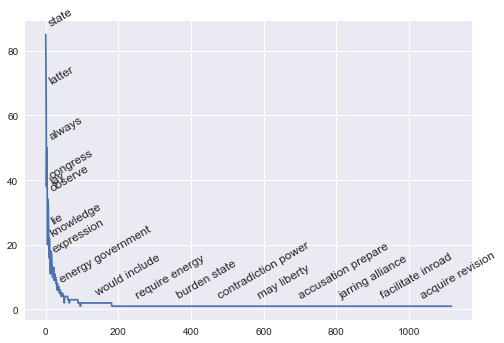

In [11]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

The application of Zipf's law in text mining comes during feature selection process. Words that occured on the left side of the diagram above e.g. state and latter are too frequent (high TF and DF). Meanwhile, words on the right side of the diagram e.g. "acquire revision" and "facilitate inroad" only appear in one document. Both groups of word have no value to our clustering process. Filtering them and only keeping the middle ones will be beneficial, and we can do this through limiting the DF of terms that get through the vectoriser.

In [12]:
# another tf idf vectoriser
# limit the terms produced to terms that occured at minimum 2 documents and maximum 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(df['Text'])

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

8938


This process greatly reduced the number of terms in our feature set. Let's try to cluster it again and see whether the clusters are more clear.

In [17]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=7, random_state=42).fit(X_filter)

Wall time: 718 ms


In [18]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: election, representative, knowledge, legislature, law, 
Top terms for cluster 1: convention, national, authority, form, republican, 
Top terms for cluster 2: upon, army, nation, national, militia, 
Top terms for cluster 3: representative, number, senate, interest, member, 
Top terms for cluster 4: president, senate, office, appointment, upon, 
Top terms for cluster 5: court, law, jurisdiction, authority, clause, 
Top terms for cluster 6: department, legislative, judiciary, legislative department, judiciary department, 


With much less terms in the feature vector, the clustering process managed to result in much more meaningful solution. You can now see clear distinction between cluster topics, like taxation (#3), military (#1), parliament (#5), etc.

### 4.2. Singular Value Decomposition

Singular value decomposition is a dimensionality reduction method that works by factorizing a matrix. You have used SVD before with PCA, also a dimensionality reduction technique. In text mining, SVD is commonly used in technique called Latent Semantic Analysis, a method of analysing documents by finding the underlying meaning or concepts of words in these documents.

[More info](https://en.wikipedia.org/wiki/Latent_semantic_analysis)

LSA is typically used to help comparing and finding similar documents (like in document clustering and classification) and also finding synonymous/polysemous relationships between words. LSA can help in increasing speed (less features) and accuracy (comparison is now based on document concept similary instead of word similarity) of the model.

In the following code, we will reduce the original `X` into only 100 components.

In [19]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_trans = svd.fit_transform(X_filter)

Each of the components produced by SVD contain weights associated with each word. The larger the weight is, the more connected the word is to the component.

In [20]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 upon, national, law, authority, representative, 
Top terms in component #1 senate, president, representative, legislative, department, 
Top terms in component #2 court, law, jurisdiction, judiciary, department, 
Top terms in component #3 president, senate, upon, treaty, appointment, 
Top terms in component #4 department, legislative, army, judiciary, republic, 
Top terms in component #5 court, treaty, cause, jurisdiction, nation, 
Top terms in component #6 interest, upon, taxation, revenue, merchant, 
Top terms in component #7 confederation, treaty, congress, article, clause, 
Top terms in component #8 amendment, republican, convention, plan, majority, 
Top terms in component #9 member, authority, state government, city, militia, 


The transformed `X` can now be used for clustering. Let's see if it improve the quality of our clusters.

In [21]:
%%time
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=7, random_state=42).fit(X_trans)

Wall time: 55 ms


SVD transformed clustering is much much faster than the normal one (55 ms vs 718 ms). Let's see if the transformation impact on the cluster characteristics.

In [22]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names())

Top terms for cluster 0: election, representative, knowledge, legislature, law, 
Top terms for cluster 1: convention, national, authority, form, republican, 
Top terms for cluster 2: upon, army, nation, national, militia, 
Top terms for cluster 3: representative, number, senate, interest, member, 
Top terms for cluster 4: president, senate, office, appointment, upon, 
Top terms for cluster 5: court, law, jurisdiction, authority, clause, 
Top terms for cluster 6: department, legislative, judiciary, legislative department, judiciary department, 


There is not much difference in the cluster topic terms between SVD-transformed feature vs normal feature. This means the original clustering solution has managed to capture the difference in concepts/topics in the document space. SVD is still beneficial due to reduced training time, which is extremely beneficial in large document clustering.